In [1]:
# import os
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/')

# from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
import scanpy as sc
import scvelo as scv

data = scv.datasets.pancreas(file_path='/Users/evanli/Documents/Research_datasets/PBMC_Hao/Hao_PBMC.h5ad')


In [3]:
# label = data.obs['celltype.l1'].tolist()
# types = np.unique(label).tolist()
types = ['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']
types

['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']

In [5]:
cts = ['CD4_T', 'CD8_T']
cts

['CD4_T', 'CD8_T']

## Read result_dict from json

In [4]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Level_1_alpha0.001/Level1_alpha0.001_result


In [12]:
import json

loss_dict = {}
opt_lambda_dict = {}
prevalence_dict = {}
precision_dict = {}
f1_dict = {}
# results = []

for celltype in cts:
    print('Processing: ', celltype)
    # /Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/PBMC_AD2_result/ASDC
    with open(f'./{celltype}_precision/{celltype}_tuning.json') as f:
        result_dict = json.load(f)
    result_dict = {key: np.array(value) for key, value in result_dict.items()}
    # results.append(result_dict)

    # opt_lmbd, fig = ad.lambda_decision(result_dict, k=2)
    # opt_lambda_dict[celltype] = opt_lmbd
    # print('Optimal lambda: {}'.format(opt_lmbd))

    # Read optimal lambda
    with open(f'./{celltype}/{celltype}_opt_lambda.txt', 'r') as f:
        opt_lmbd = float(f.read())
    opt_lambda_dict[celltype] = opt_lmbd

    loss_dict[celltype] = result_dict['loss_history']
    prevalence_dict[celltype] = result_dict['Prevalence']
    precision_dict[celltype] = result_dict['Precision']
    f1_dict[celltype] = result_dict['F1 score']

Processing:  CD4_T
Processing:  CD8_T


In [13]:
opt_lambda_dict

{'CD4_T': 0.0014677992676220707, 'CD8_T': 0.003162277660168382}

In [14]:
precision_dict

{'CD4_T': array([0.97991479, 0.98108747, 0.97613365, 0.97290485, 0.97968937,
        0.9742823 , 0.9753012 , 0.97543439, 0.97349823, 0.95446266,
        0.94775213, 0.93921335, 0.90742996, 0.8922619 , 0.91354293,
        0.90748899, 0.91325898, 0.89503106, 0.84972171, 0.85651903,
        0.82860666, 0.77819549, 0.        , 0.        , 0.        ]),
 'CD8_T': array([0.95303327, 0.96233895, 0.95061728, 0.95045501, 0.94970414,
        0.9410609 , 0.94066986, 0.95721393, 0.93859649, 0.93333333,
        0.92531523, 0.92443572, 0.91624622, 0.89545015, 0.84668645,
        0.87325349, 0.8004012 , 0.77982646, 0.68881506, 0.66829865,
        0.62612613, 0.60970874, 0.61728395, 0.        , 0.        ])}

In [15]:
f1_dict

{'CD4_T': array([0.98290598, 0.98050797, 0.97613365, 0.97597977, 0.97939683,
        0.97661871, 0.98032092, 0.9748503 , 0.97064005, 0.95736906,
        0.95063985, 0.94173887, 0.91439092, 0.89679928, 0.91464891,
        0.90096845, 0.90346307, 0.88868332, 0.85500933, 0.84936591,
        0.82733149, 0.77094972, 0.        , 0.        , 0.        ]),
 'CD8_T': array([0.95070766, 0.94731707, 0.94478528, 0.94614997, 0.9455081 ,
        0.9337232 , 0.94428434, 0.94406281, 0.93586006, 0.92561983,
        0.9137931 , 0.9154519 , 0.90618762, 0.89070775, 0.85986941,
        0.87939698, 0.78196962, 0.74430642, 0.64589823, 0.58364511,
        0.50423216, 0.40385852, 0.34867503, 0.        , 0.        ])}

In [16]:
# with open('./Pancreas_ADlasso/Pancreas_result/opt_lambda.json', 'w') as f:
#     json.dump(opt_lambda_dict, f)

## Plot summary loss vs. prevalance

In [17]:
log_lmbd_range = np.linspace(np.log(1e-4), np.log(1), 25)
lmbd_range = np.exp(log_lmbd_range)
print(lmbd_range)

[1.00000000e-04 1.46779927e-04 2.15443469e-04 3.16227766e-04
 4.64158883e-04 6.81292069e-04 1.00000000e-03 1.46779927e-03
 2.15443469e-03 3.16227766e-03 4.64158883e-03 6.81292069e-03
 1.00000000e-02 1.46779927e-02 2.15443469e-02 3.16227766e-02
 4.64158883e-02 6.81292069e-02 1.00000000e-01 1.46779927e-01
 2.15443469e-01 3.16227766e-01 4.64158883e-01 6.81292069e-01
 1.00000000e+00]


In [25]:
# create color palette for 8 cell types
import seaborn as sns

keys = list(loss_dict.keys())
palette = sns.color_palette('tab10', n_colors=len(keys))
# palette = ['red', 'blue']
color_dict = dict(zip(keys, palette))

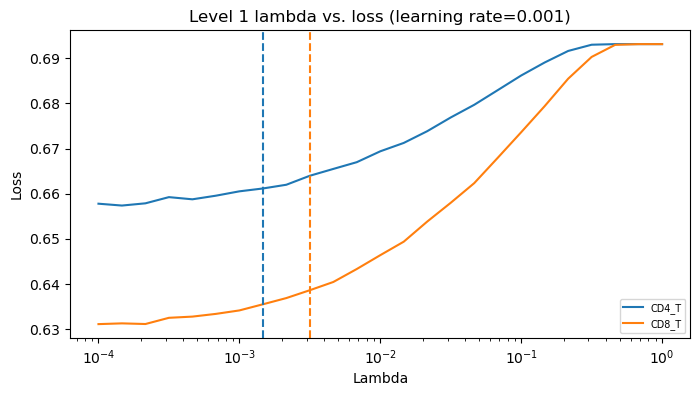

In [26]:
# Plot the loss history against lambda
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

# plot the y-axis values for each key in loss_dict
for key in loss_dict:
    ax.plot(lmbd_range, loss_dict[key], label=key, color=color_dict[key])

# add vertical dotted lines at the values in opt_lambda_dict
for key in opt_lambda_dict:
    ax.axvline(x=opt_lambda_dict[key], linestyle='--', color=color_dict[key])

# set the x-axis label
ax.set_xlabel('Lambda')
ax.set_xscale('log')

# set the y-axis label
ax.set_ylabel('Loss')

# add a legend
ax.legend(loc='lower right', fontsize='x-small')

plt.title('Level 1 lambda vs. loss (learning rate=0.001)')
# show the plot
plt.show()

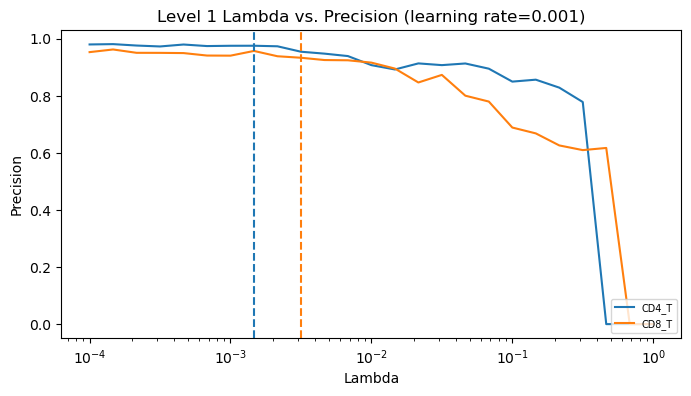

In [30]:
# Plot the precision against lambda
fig, ax = plt.subplots(figsize=(8, 4))

# plot the y-axis values for each key in loss_dict
for key in precision_dict:
    ax.plot(lmbd_range, precision_dict[key], label=key, color=color_dict[key])

# add vertical dotted lines at the values in opt_lambda_dict
for key in opt_lambda_dict:
    ax.axvline(x=opt_lambda_dict[key], linestyle='--', color=color_dict[key])

# set the x-axis label
ax.set_xlabel('Lambda')
ax.set_xscale('log')

# set the y-axis label
ax.set_ylabel('Precision')

# add a legend
ax.legend(loc='lower right', fontsize='x-small')

plt.title('Level 1 Lambda vs. Precision (learning rate=0.001)')
# show the plot
plt.show()

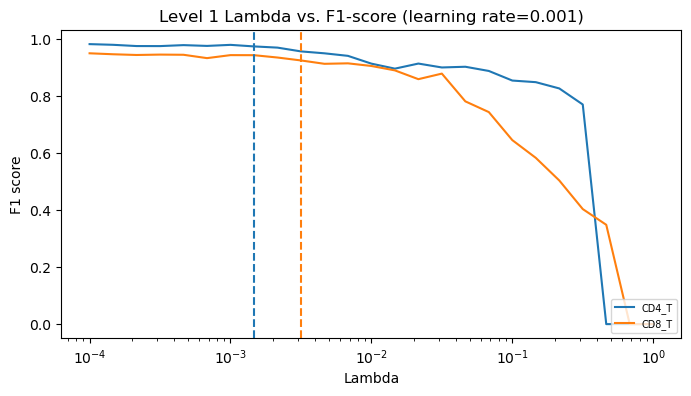

In [32]:
# Plot the f1-score against lambda
fig, ax = plt.subplots(figsize=(8, 4))

# plot the y-axis values for each key in loss_dict
for key in f1_dict:
    ax.plot(lmbd_range, f1_dict[key], label=key, color=color_dict[key])

# add vertical dotted lines at the values in opt_lambda_dict
for key in opt_lambda_dict:
    ax.axvline(x=opt_lambda_dict[key], linestyle='--', color=color_dict[key])

# set the x-axis label
ax.set_xlabel('Lambda')
ax.set_xscale('log')

# set the y-axis label
ax.set_ylabel('F1 score')

# add a legend
ax.legend(loc='lower right', fontsize='x-small')

plt.title('Level 1 Lambda vs. F1-score (learning rate=0.001)')
# show the plot
plt.show()